In [1]:
# Crop_up is the numpy array data for the up_stream 001m. Crop_down is down_stream 001m. 

In [38]:
import numpy as np

arr = np.load("new_data.npy")


In [39]:
# There are 72 smaller images in both up and down stream. Now together there are 144. 
# The shape of the data (144,128,128,1) means the batch size is 144, each one has 128x128 pixels, and the color channel is 1, grey-scaled.
# The data is also normalized to (0,1) for the model to perform better.

In [40]:
import numpy as np



# 1. Normalize the data
data_min = np.nanmin(arr)
data_max = np.nanmax(arr)
normalized_data = (arr - data_min) / (data_max - data_min)
arr_without_nan = np.nan_to_num(normalized_data, nan=0)
# 2. Reshape the data
data = arr_without_nan.reshape((38, 512, 512, 1))


In [41]:
data.min()

0.0

In [42]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

# Encoder
input_img = Input(shape=(512, 512, 1))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

latent_dim = 128 # Adjust as needed
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(128 * 128 * 64, activation='relu')(decoder_input)
x = Reshape((128, 128, 64))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoded, name='decoder')

outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconstruction_loss *= 512 * 512 
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [43]:
# Encoder
input_img = Input(shape=(512, 512, 1))

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)

latent_dim = 128 # Increased latent dimension
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')

# Decoder
decoder_input = Input(shape=(latent_dim,))
x = Dense(64 * 64 * 256, activation='relu')(decoder_input) 
x = Reshape((64, 64, 256))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

decoder = Model(decoder_input, decoded, name='decoder')

outputs = decoder(encoder(input_img)[2])
vae = Model(input_img, outputs, name='vae')

reconstruction_loss = binary_crossentropy(K.flatten(input_img), K.flatten(outputs))
reconstruction_loss *= 512 * 512 
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [44]:
vae.fit(data, epochs=50, batch_size=19, shuffle=True)


Epoch 1/50
2/2 [==============================] - 24s 10s/step - loss: 310158688256.0000
Epoch 2/50
2/2 [==============================] - 21s 10s/step - loss: 182281.6875
Epoch 3/50
2/2 [==============================] - 21s 10s/step - loss: 180896.5312
Epoch 4/50
2/2 [==============================] - 21s 10s/step - loss: 180778.7188
Epoch 5/50
2/2 [==============================] - 21s 10s/step - loss: 181288.3125
Epoch 6/50
2/2 [==============================] - 21s 10s/step - loss: 180319.6250
Epoch 7/50
2/2 [==============================] - 21s 10s/step - loss: 179432.3125
Epoch 8/50
2/2 [==============================] - 21s 10s/step - loss: 177189.2656
Epoch 9/50
2/2 [==============================] - 21s 10s/step - loss: 174494.1875
Epoch 10/50
2/2 [==============================] - 21s 10s/step - loss: 171112.1875
Epoch 11/50
2/2 [==============================] - 21s 10s/step - loss: 161157.8750
Epoch 12/50
2/2 [==============================] - 21s 10s/step - loss: 162609.

In [8]:
# Higher batch size may cost more computing resourses, it means calculating more image at the same time.

1/1 [==============================] - 0s 284ms/step


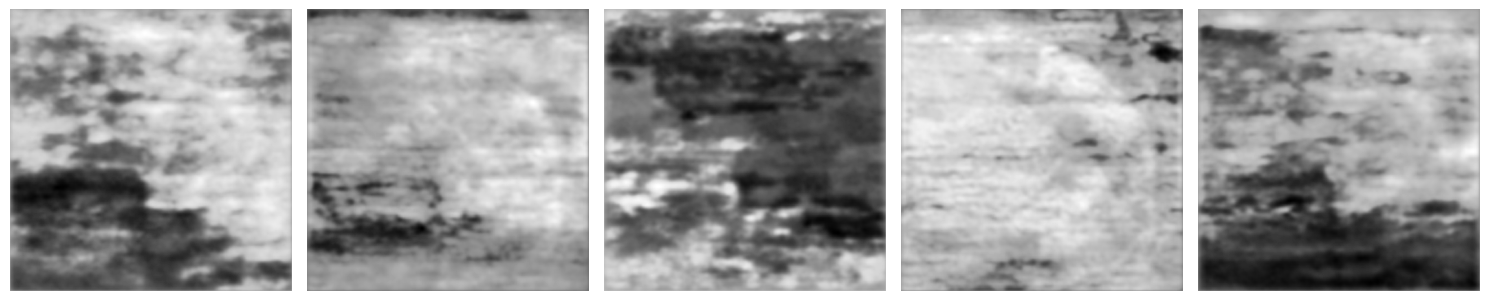

In [50]:
import matplotlib.pyplot as plt

def generate_images(decoder, n=5):
    # Sample from the latent space
    latent_dim = 128  # This is the latent_dim defined in the VAE model
    random_latent_vectors = np.random.normal(size=(n, latent_dim))

    # Decode to generate images
    generated_images = decoder.predict(random_latent_vectors)
    
    return generated_images

# Generate new images
new_images = generate_images(decoder, n=5)

# Plot the generated images
plt.figure(figsize=(15, 5))

for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(new_images[i].reshape(512, 512), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()
